# Predicting Stock Prices with Technical Indicators

#### New Technical terms 

1) Simple Moving Average (SMA):
The SMA is one of the most fundamental indicators. It takes the `average` of a stock's closing price over a specific number of days. In our code, we're using a 10-day SMA and a 50-day SMA.
    - *Why is it useful?* The SMA helps to smooth out price data, making it easier to see the overall trend. A short-term SMA (like the 10-day) reacts quickly to price changes, while a long-term SMA (like the 50-day) is much slower and shows the bigger picture. When a short-term SMA crosses above a long-term SMA, it's often seen as a bullish signal (a sign of a rising trend), and a cross below is a bearish signal (a sign of a falling trend). By including these as features, our model can learn these trend-following patterns.
2) Relative Strength Index (RSI):
The RSI is a momentum indicator. It measures the `speed and magnitude` of recent price changes to evaluate overbought or oversold conditions in the price of a stock. The RSI is displayed as an **oscillator**, a line graph that moves between two extremes, and is typically a value from 0 to 100.
    - Why is it useful? A high RSI (typically above 70) suggests that the stock is overbought, meaning its price has risen too quickly and might be due for a correction. A low RSI (typically below 30) suggests the stock is oversold, meaning its price has fallen too quickly and might be due for a bounce back. By feeding the RSI into our model, we're giving it information about the "mood" or momentum of the market, which can be a strong predictor of short-term price movements.[source](https://www.oanda.com/us-en/trade-tap-blog/trading-knowledge/understanding-the-relative-strength-index/#:~:text=What%20is%20the%20Relative%20Strength,Technical%20Trading%20Systems%20in%201978.)
    - How it helps our model: By including the RSI as a feature, we're giving our model a powerful piece of information about market psychology. The model can learn that when a stock enters "overbought" territory (e.g., RSI > 70), there's a higher probability of a price decrease in the near future. Conversely, an "oversold" signal (RSI < 30) could suggest a potential buying opportunity.
3) Moving Average Convergence Divergence (MACD) : MACD offers a visual representation of the ups and downs in price action as influenced by market volatility. It is a powerful and widely used momentum indicator in financial analysis. It's designed to help identify the strength, direction, momentum, and duration of a stock's trend. Unlike the Simple Moving Average (SMA) which shows a simple average of prices, the MACD provides a more `dynamic view of the relationship between two different moving averages`. It's essentially a tool for spotting changes in momentum. 
    - why is it useful? It provides the direction of momentum and trend direction. It's often used by traders to spot potential buy and sell signals. The MACD is most effective in trending markets—when the price is moving clearly up or down. Here's why:

        - Trend Identification: The MACD line crossing above the zero line can signal a strong uptrend, while crossing below it suggests a downtrend.

        - Momentum Changes: When the MACD line crosses the signal line, it can indicate a shift in momentum. A crossover above the signal line is a bullish signal (potential buy), and a crossover below is a bearish signal (potential sell).

        - Divergence: This is one of its most powerful uses. When the price of an asset makes a new high but the MACD makes a lower high, it's called a bearish divergence and can signal that the upward momentum is weakening. The opposite is a bullish divergence, which can signal that a downtrend is losing steam.
    - Like all indicators, MACD has limitations, especially in certain market conditions.

        - Lagging Indicator: The MACD is based on past price data, so it's a lagging indicator. This means it can sometimes give signals after a significant price move has already happened.

        - Sideways Markets: In choppy or sideways markets (when the price is not trending), the MACD can generate frequent, false signals. This is because the moving averages can cross over and back repeatedly, leading to "whipsaws" and potential losses.

       - Stand-alone Tool: The MACD is not meant to be used on its own. It's most effective when used with other indicators or analysis methods, such as volume or price action, to confirm its signals.



    MACD formula = 12-day period EMA - 26-day period EMA (EMA - expotentially moving average[check its calculationg below])

    <img src="../static/MACD.png" alt="MACD chart showing a stock price line with two exponential moving averages, one in blue and one in orange, and the MACD indicator below as a bar chart with positive and negative values. The chart illustrates the convergence and divergence of the moving averages, highlighting momentum shifts. The environment is analytical and focused on technical analysis for stock trading. No emotional tone is present." width=200/>

    <img src="../static/MACD_signal.png" alt="MACD signal chart displaying a stock price line with two exponential moving averages, one in red and one in yellow, and the MACD indicator below showing green and red shaded areas. Crossover points are marked with circles. The chart legend includes XYZ, 12-day EMA, 26-day EMA, and MACD. The environment is analytical and focused on technical analysis for stock trading. No emotional tone is present." width=200/>

**Exponential Moving Average (EMA):**

The EMA is a type of moving average that places a greater weight and significance on the most recent data points. It reacts more quickly to recent price changes than the Simple Moving Average (SMA).

**EMA Calculation Steps:**
1. **Calculate the Multiplier:**
   
   Multiplier = 2 / (N + 1)
   
   where N is the number of periods.

2. **Calculate the EMA:**
   - The first EMA value is the SMA of the first N periods.
   - For the next values:

     EMA_today = (Price_today - EMA_yesterday) × Multiplier + EMA_yesterday

**Why use EMA?**
- EMA gives more weight to recent prices, making it more responsive to new information.
- It is widely used in technical analysis to identify trends and potential buy/sell signals.



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_52202/3432105183.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2018-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed



Downloaded data for: GOOG
Price           Close       High        Low       Open    Volume
Ticker           GOOG       GOOG       GOOG       GOOG      GOOG
Date                                                            
2018-01-02  52.935345  53.031772  51.952687  52.107267  24752000
2018-01-03  53.804180  53.993553  52.846373  52.901048  28604000
2018-01-04  53.999020  54.355403  53.879828  54.078549  20092000
2018-01-05  54.785843  54.886248  54.277364  54.376775  25582000
2018-01-08  55.019951  55.235171  54.755524  54.785842  20952000
length of X: 1459
Random Forest MSE: 8.877711506473899
SVR MSE: 5.671753832759511
Random Forest MSE: 8.877711506473899
SVR MSE: 5.671753832759511


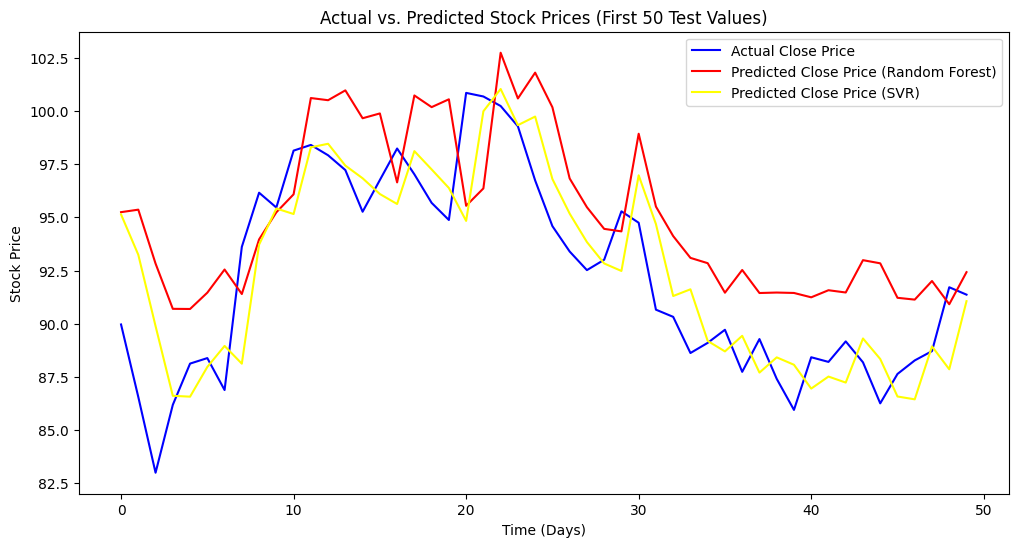

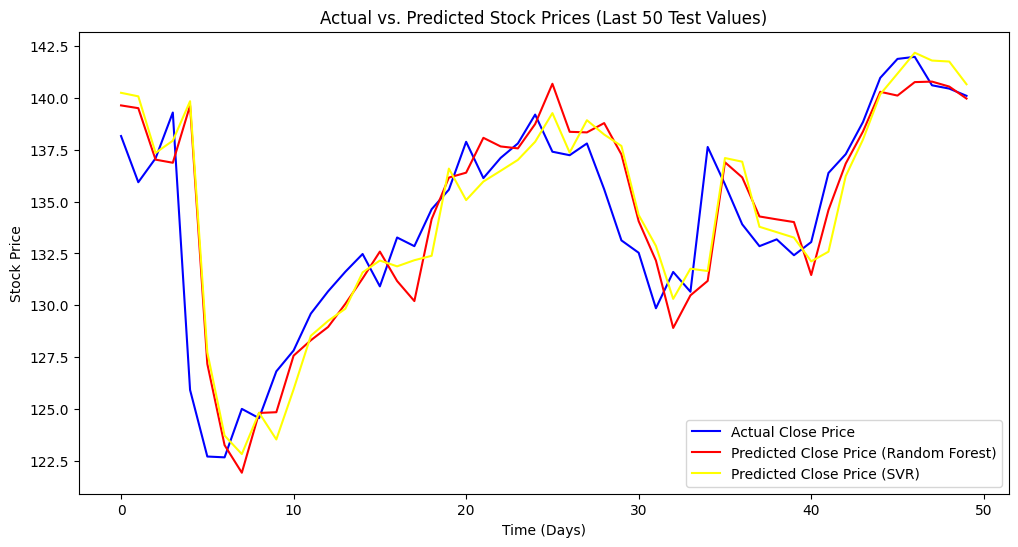

In [5]:
# Creating Advance technical features
#Fetch the stock data 
ticker = 'GOOG'
data = yf.download(ticker, start='2018-01-01', end='2024-01-01')
print("Downloaded data for:", ticker)
print(data.head())

# 2) Relative Strength Index (RSI):
def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain/loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 1) Simple Moving Average (SMA): low and medium term
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['RSI_14'] = compute_rsi(data)

# Prepare the data
data['Next Close'] = data['Close'].shift(-1)

data = data.dropna()

X = data[['Open', 'High', 'Low', 'Volume', 'SMA_20', 'SMA_50', 'RSI_14']]
y = data['Next Close']

print("length of X:", len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Feature Scaling for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest MSE: {mse_rf}')

# Model 2: Support Vector Regressor (SVR)
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f'SVR MSE: {mse_svr}')

# Visualizing the results for the second model
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:50], label='Actual Close Price', color='blue')
plt.plot(y_pred_rf[:50], label='Predicted Close Price (Random Forest)', color='red')
plt.plot(y_pred_svr[:50], label='Predicted Close Price (SVR)', color='yellow')
plt.title('Actual vs. Predicted Stock Prices (First 50 Test Values)')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.values[-50:], label='Actual Close Price', color='blue')
plt.plot(y_pred_rf[-50:], label='Predicted Close Price (Random Forest)', color='red')
plt.plot(y_pred_svr[-50:], label='Predicted Close Price (SVR)', color='yellow')
plt.title('Actual vs. Predicted Stock Prices (Last 50 Test Values)')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_52202/4262412655.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2018-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed



Downloaded data for: GOOG
Price           Close       High        Low       Open    Volume
Ticker           GOOG       GOOG       GOOG       GOOG      GOOG
Date                                                            
2018-01-02  52.935345  53.031772  51.952687  52.107267  24752000
2018-01-03  53.804180  53.993553  52.846373  52.901048  28604000
2018-01-04  53.999020  54.355403  53.879828  54.078549  20092000
2018-01-05  54.785843  54.886248  54.277364  54.376775  25582000
2018-01-08  55.019951  55.235171  54.755524  54.785842  20952000
Random Forest with MACD MSE: 9.15038168133645
SVR with MACD MSE: 8.58661197307565
Random Forest with MACD MSE: 9.15038168133645
SVR with MACD MSE: 8.58661197307565


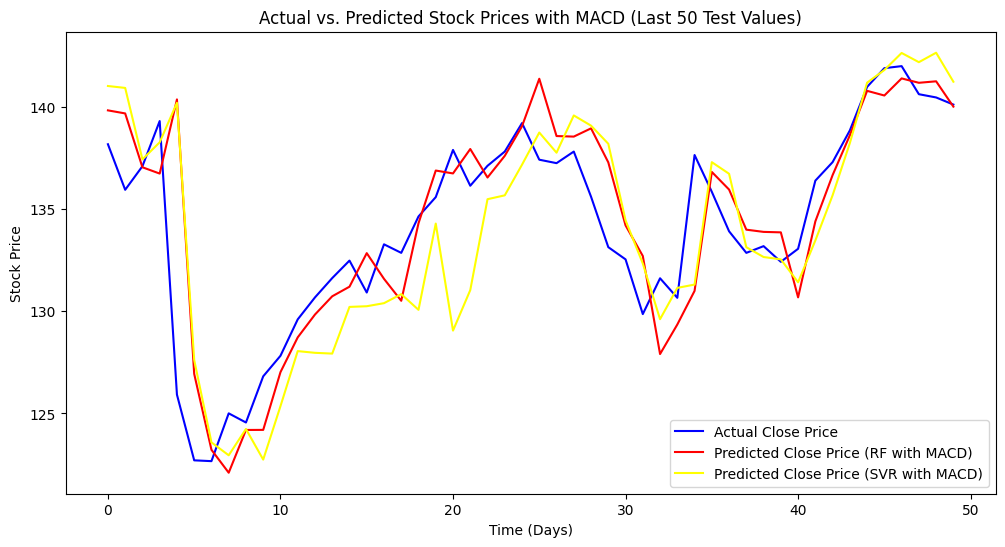

In [13]:
# Now we will add another technical indicator MACD for futher analysis 
ticker = 'GOOG'
data = yf.download(ticker, start='2018-01-01', end='2024-01-01')
print("Downloaded data for:", ticker)
print(data.head())

# Relative Strength Index (RSI):
def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain/loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    #Calculate the MACD line = 12-day EMA - 26-day EMA
    data['EMA_12'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']

    #Calculate the signal line = EMA over 9-day period
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    return data

# Simple Moving Average (SMA): low and medium term
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['RSI_14'] = compute_rsi(data)
data = compute_macd(data)

# Prepare the data
data['Next Close'] = data['Close'].shift(-1)


# Prepare the data again after adding MACD
data = data.dropna()

# Adding MACD to the features
X = data[['Open', 'High', 'Low', 'Volume', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'SMA_20', 'SMA_50', 'RSI_14']]
y = data['Next Close']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Model 1: Random Forest Regressor with MACD
rf_model_macd = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_macd.fit(X_train, y_train)
y_pred_rf_macd = rf_model_macd.predict(X_test)
mse_rf_macd = mean_squared_error(y_test, y_pred_rf_macd)
print(f'Random Forest with MACD MSE: {mse_rf_macd}')

# Model 2: Support Vector Regressor (SVR) with MACD
svr_model_macd = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model_macd.fit(X_train_scaled, y_train)
y_pred_svr_macd = svr_model_macd.predict(X_test_scaled)
mse_svr_macd = mean_squared_error(y_test, y_pred_svr_macd)
print(f'SVR with MACD MSE: {mse_svr_macd}')

# Visualizing the results for the second model with MACD
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[-50:], label='Actual Close Price', color='blue')
plt.plot(y_pred_rf_macd[-50:], label='Predicted Close Price (RF with MACD)', color='red')
plt.plot(y_pred_svr_macd[-50:], label='Predicted Close Price (SVR with MACD)', color='yellow')
plt.title('Actual vs. Predicted Stock Prices with MACD (Last 50 Test Values)')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

- Original MSE with SMA-20, SMA-50:

   - Random Forest: 8.88

   - SVR: 5.67

- MSE with MACD:

    - Random Forest: 9.15

    - SVR: 8.59

The model seems to get worse, their could be couple of reasons for it. Let's go through them one-by-one. 
1. Redundancy: The original model already included two Simple Moving Averages (SMA_20 and SMA_50). The MACD is also based on moving averages (Exponential Moving Averages, or EMAs), so the information it provides might have been too similar to the existing features. This can confuse the model and make it harder to find the true relationship between the features and the target.

2. Noise: In some cases, adding a new feature—especially one that generates false signals in certain market conditions, as we discussed earlier—can introduce more "noise" than useful information. This noise can make the model's predictions less reliable.

3. Model Sensitivity: The SVR model showed a much larger increase in MSE than the Random Forest model. This could indicate that the SVR model is more sensitive to the type of information (or noise) that the MACD feature introduced.

In summary, the data suggests that MACD was not a helpful feature for your specific models and dataset. It's a great example of how you need to test and validate every feature to see if it actually improves your model's predictive power.